In [488]:
import pandas as pd
import numpy as np
from collections import Counter
import random as r
from sklearn.model_selection import train_test_split
dt = pd.read_csv('../data/model4.csv').dropna()
# dt['car'] = dt['TS_MARK_NAME'] + ' ' + dt['TS_MODEL_NAME']

# откуда то при пересохранении в csv образуется лишний столбец
dt.drop(dt.columns[[0]], axis = 1, inplace = True)

dt.OWN_REG = dt.OWN_REG.apply(lambda x: str(x))
dt = dt[(dt['TS_POWER'] < 1000) & (dt['TS_POWER'] > 30) & (dt['INS_YEAR'] > 18)]
dt = dt[['AGR_SRC', 'AGR_CREATEDBY',#, 'car' 
       'OWN_REG', 'AGR_KBM', 'TS_MARK_NAME', 'TS_MODEL_NAME',
       'TS_POWER', 'TS_USE_NAME', 'f1_daysbeforestart',
       'f6_car_age_on_start', 'f13_is_prolongation', 'f14_drivers_count',
       'f15_kbm_min', 'f16_drv_age_min', 'f17_drv_age_max',
       'f18_drv_skill_min', 'f19_drv_skill_max', 'f20_oneperson',
       'f21_agr_days', 'claim']]

# балансируем классы и разбиваем на выборки
dt['cat'] = dt['claim'].apply(lambda x: r.choice(list(range(1, 6))) if x==1 else r.choice(list(range(10, 30))))
trn = dt[dt['cat'].isin([10, 2, 3, 4, 5, 22, 23, 24, 25, 26, 27, 28, 29])]
tst = dt[dt['cat'].isin([1,11, 12, 13, 14, 15])].drop('cat', axis = 1)

dt2 = trn[(trn['AGR_KBM'] < 0.95) & (trn['AGR_KBM'] > 1)]
dt3 = trn[trn['claim'] == 1]
# print(dt3.shape, Counter(dt3.claim))
dt = dt.append(dt2).append(dt3)


# пополняем выборку значениями upsample
trn = dt[dt['cat'].isin([10, 2, 3, 4, 5, 22,])].drop('cat', axis = 1)

# for c in dt.columns:
#     col_type = dt[c].dtype
#     if col_type == 'object' or col_type.name == 'category':
#         X[c] = dt[c].astype('category')




X = dt.drop(['claim'], axis = 1)
Y = dt.claim


X_train = trn.drop(['claim'], axis = 1)
X_test = tst.drop(['claim'], axis = 1)
y_train = trn.claim
y_test = tst.claim

print(Counter(y_train), Counter(y_test))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Counter({0: 7419, 1: 5654}) Counter({0: 18749, 1: 733})


In [439]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41609 entries, 0 to 81970
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGR_SRC              41609 non-null  object 
 1   AGR_CREATEDBY        41609 non-null  object 
 2   INS_NAME             41609 non-null  object 
 3   INS_SEX              41609 non-null  object 
 4   INS_YEAR             41609 non-null  float64
 5   INS_REG              41609 non-null  float64
 6   INS_DOCSER           41609 non-null  object 
 7   OWN_NAME             41609 non-null  object 
 8   OWN_SEX              41609 non-null  object 
 9   OWN_YEAR             41609 non-null  float64
 10  OWN_REG              41609 non-null  float64
 11  OWN_DOCSER           41609 non-null  object 
 12  AGR_KBM              41609 non-null  float64
 13  TS_CATEGORY          41609 non-null  object 
 14  TS_MARK_NAME         41609 non-null  object 
 15  TS_MODEL_NAME        41609 non-null 

In [479]:
from scipy.optimize import minimize
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report,f1_score

def mtr(m, x = X_test, y = y_test, limit = 0, metrics = 'AUC'):
#     print(len(x), len(y))
    pr = m.predict(x)
    meanclaim = 51304
    meanpremium = 6946
    meankv = 0.18
#     print(pr)
    if limit == 0:
        pred = pr
    elif limit == 1:
        def min(limit, m=m):
            s = m.predict_proba(x)
            r = []
            for i in s:
                if i[0] > limit:
                    r.append(0)
                else:
                    r.append(1)
            if metrics == 'AUC':
                res = roc_auc_score(y, r)
            elif metrics == 'money':
                cm = confusion_matrix(y, r)
                res = (cm[0][0] + cm[1][0])*meanpremium*(1-meankv) - cm[1][0]*meanclaim
                
            return -res
        l = minimize(min, 0.5, method='COBYLA')['x']
        print ('Оптимальный лимит: ', l)
        print('')
        s = m.predict_proba(x)
        pred = []
        for i in s:
            if i[0] > l:
                pred.append(0)
            else:
                pred.append(1)
        
    else:
        s = m.predict_proba(x)
        pred = []
        for i in s:
            if i[0] > limit:
                pred.append(0)
            else:
                pred.append(1)
    cmf = confusion_matrix(y, pred)
    print('Всего сборов: ',  (cmf[0][0] + cmf[1][0])*meanpremium)
    print('Всего доход: ',  (cmf[0][0] + cmf[1][0])*meanpremium*(1-meankv) - cmf[1][0]*meanclaim)
    
    print('')
    print(cmf)
    print('')
    print(classification_report(y, pred))
    print('')
    print('ROC-AUC score: ', roc_auc_score(y, pred))
    
mtr(modelcb, x = X_test, y = y_test, limit = 1, metrics = 'AUC')
    

Оптимальный лимит:  0.85097421875

Всего сборов:  198725060
Всего доход:  145049453.20000002

[[28261 12592]
 [  349   359]]

              precision    recall  f1-score   support

           0       0.99      0.69      0.81     40853
           1       0.03      0.51      0.05       708

    accuracy                           0.69     41561
   macro avg       0.51      0.60      0.43     41561
weighted avg       0.97      0.69      0.80     41561


ROC-AUC score:  0.5994175444521289


In [489]:
from catboost import CatBoostClassifier, Pool

categorical_features = ['AGR_CREATEDBY', 'OWN_REG', 'AGR_SRC', #'car',
                         'TS_MODEL_NAME', 'TS_MARK_NAME',
       'TS_USE_NAME']

text_features = []#['INS_NAME']

cat_features_index = list(X_train.columns.get_loc(feature) for feature in categorical_features)
text_features_index = list(X_train.columns.get_loc(feature) for feature in text_features)

In [490]:
modelcb = CatBoostClassifier(
                learning_rate=0.01,
#                 l2_leaf_reg=6,
#                 grow_policy = 'Lossguide',
                loss_function='Logloss',
#                 depth=16,
#                 iterations=30,
                eval_metric='AUC', #AUC, F1
                cat_features=cat_features_index,
                text_features=text_features_index,
        #         random_seed=42,
                logging_level='Silent',
#                 task_type="GPU",
#                 devices='1'
            )

modelcb.fit(X_train, y_train)

mtr(modelcb, x = X_test, y = y_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.810102734375

Всего сборов:  66285678
Всего доход:  43016071.96

[[9322 9427]
 [ 221  512]]

              precision    recall  f1-score   support

           0       0.98      0.50      0.66     18749
           1       0.05      0.70      0.10       733

    accuracy                           0.50     19482
   macro avg       0.51      0.60      0.38     19482
weighted avg       0.94      0.50      0.64     19482


ROC-AUC score:  0.5978495842652308


In [475]:
mtr(modelcb, x = X_test, y = y_test, limit = 1, metrics = 'F1')

Оптимальный лимит:  1.5

Всего сборов:  0
Всего доход:  0.0

[[    0 40853]
 [    0   708]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     40853
           1       0.02      1.00      0.03       708

    accuracy                           0.02     41561
   macro avg       0.01      0.50      0.02     41561
weighted avg       0.00      0.02      0.00     41561


ROC-AUC score:  0.5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [450]:
mtr(modelcb, x = X, y = Y, limit = 1, metrics = 'money')

Оптимальный лимит:  0.386274609375

Всего сборов:  461137994
Всего доход:  339296027.08000004

[[65632  9000]
 [  757  5688]]

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     74632
           1       0.39      0.88      0.54      6445

    accuracy                           0.88     81077
   macro avg       0.69      0.88      0.73     81077
weighted avg       0.94      0.88      0.90     81077


ROC-AUC score:  0.8809764524663078


In [239]:
# modelcb.save_model('../models/cb_model4_v2_06214.cbm', format="cbm")

Text(0.5, 0, 'Relative Importance')

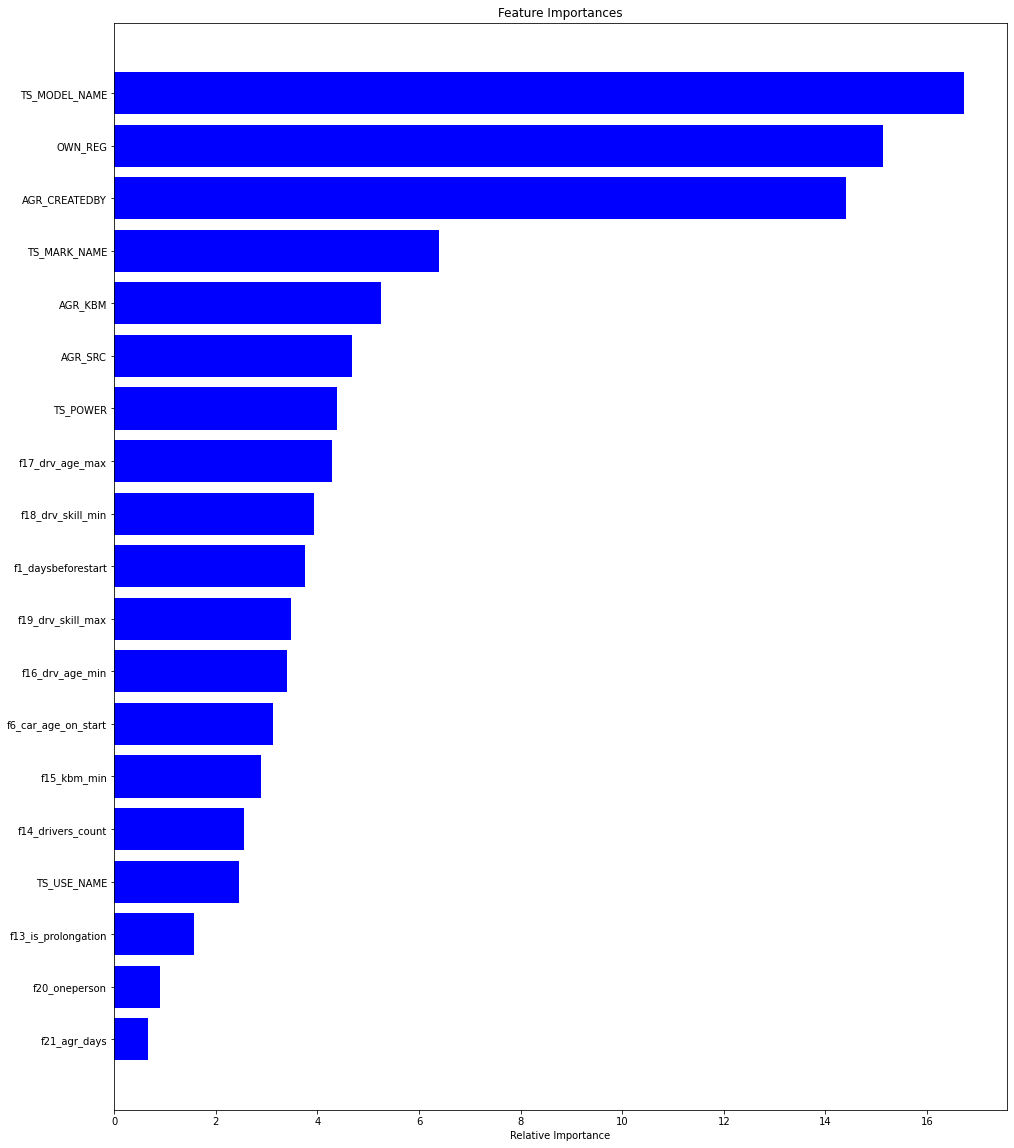

In [421]:
import matplotlib.pyplot as plt

features=X_train.columns
importances = modelcb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16, 20))
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [422]:
pr = modelcb.predict(X_test)
res = X_test
res['pred'] = pr
res['truth'] = y_test
a = confusion_matrix(y_test, pr)
print(a)
# res[(res['pred'] == res['truth']) & res['pred'] == 1]
# a[0][0] + a[1][0] - a[1][0]


[[28947 12069]
 [  119  1285]]


<AxesSubplot:xlabel='AGR_KBM'>

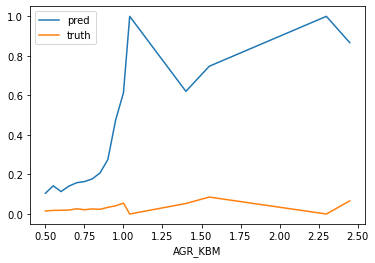

In [429]:
kbmmean = res.groupby(['AGR_KBM']).mean()[['pred', 'truth']]
kbmmean.plot()

<ipython-input-424-5428cfd64a61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powermean['TS_POWER_G'] = powermean['TS_POWER'].apply(lambda x: round(x * 2, -2) // 2)


<AxesSubplot:xlabel='TS_POWER_G'>

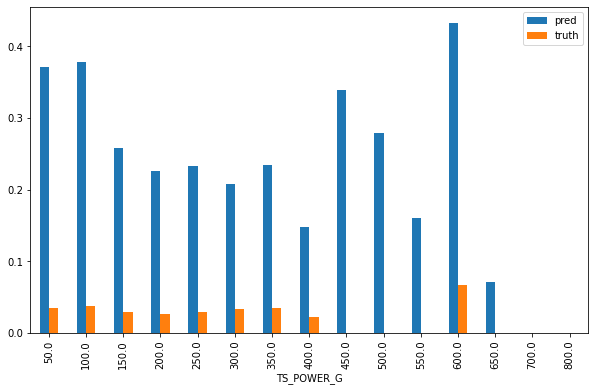

In [424]:
powermean = res[['TS_POWER', 'pred', 'truth']]
powermean['TS_POWER_G'] = powermean['TS_POWER'].apply(lambda x: round(x * 2, -2) // 2)
powermean = powermean.groupby(['TS_POWER_G']).mean()[['pred', 'truth']].sort_values(by='TS_POWER_G', ascending=True)
powermean.plot(kind = 'bar', figsize=(10, 6))

# powermean.head()
# powermean.plot(kind = 'bar', figsize=(10, 6))

<AxesSubplot:xlabel='TS_MARK_NAME'>

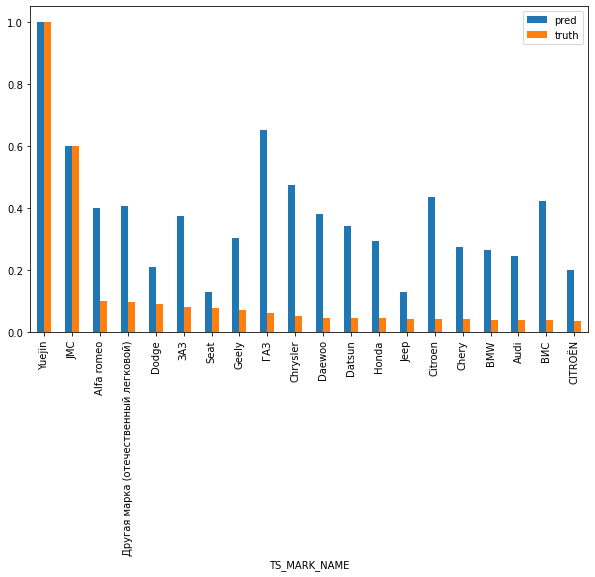

In [425]:
#аварийность по маркам

markmean = res.groupby(['TS_MARK_NAME']).mean()[['pred', 'truth']].sort_values(by='truth', ascending=False)
markmean.head(20).plot(kind = 'bar', figsize=(10, 6))

<AxesSubplot:xlabel='OWN_REG'>

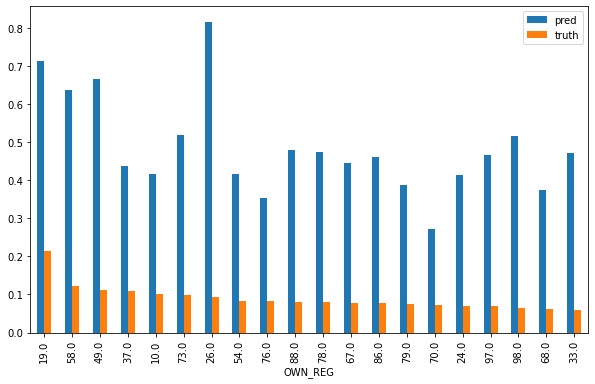

In [426]:
#аварийность по регионам

regmean = res.groupby(['OWN_REG']).mean()[['pred', 'truth']].sort_values(by='truth', ascending=False)
regmean.head(20).plot(kind = 'bar', figsize=(10, 6))

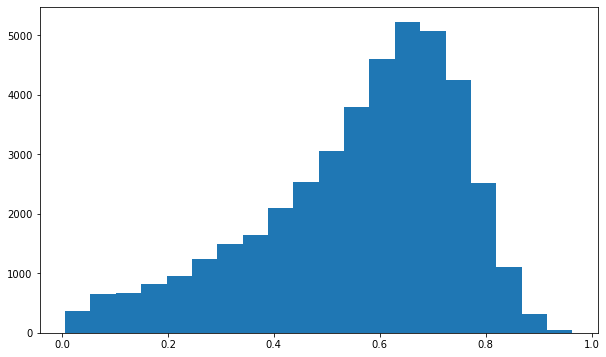

In [427]:
# распределение вероятности внутри результата

pr = modelcb.predict_proba(X_test)
proba = [a[0] for a in pr]
proba

plt.figure(figsize=(10, 6))
plt.hist(proba, bins=20)
plt.show()